[View in Colaboratory](https://colab.research.google.com/github/UjjwalSaxena/road-glare-removal-tests/blob/master/mapping.ipynb)

In [0]:
# !pip install moviepy
# !pip install imutils
# import cv2
# import time
# import matplotlib.pyplot as plt
# import moviepy
# from moviepy.editor import VideoFileClip
# import glob
# %matplotlib inline
# import numpy as np
# import imutils

In [181]:
# def upload_files():
#   from google.colab import files
#   uploaded = files.upload()
#   for k, v in uploaded.items():
#     open(k, 'wb').write(v)
#   return list(uploaded.keys())

# upload_files()

!mv "VID_20180906_183242263.mp4" "test8.mp4"
# !mv "VID_20180905_230058440.mp4" "test2.mp4"
# !mv "VID_20180905_230112639.mp4" "test3.mp4"
!ls -lrt
# !mkdir "video_frames"

total 89544
drwxr-xr-x 2 root root     4096 Aug 31 20:42 sample_data
-rw-r--r-- 1 root root 10079771 Sep  6 06:06 test1.mp4
-rw-r--r-- 1 root root 11128980 Sep  6 06:08 test2.mp4
-rw-r--r-- 1 root root 14292943 Sep  6 06:12 test3.mp4
-rw-r--r-- 1 root root 11398873 Sep  6 06:50 test4.mp4
-rw-r--r-- 1 root root 15837610 Sep  6 09:57 test5.mp4
-rw-r--r-- 1 root root  7619569 Sep  6 10:55 test6.mp4
-rw-r--r-- 1 root root 13524140 Sep  6 13:05 test7.mp4
-rw-r--r-- 1 root root  7791535 Sep  6 13:15 test8.mp4


In [0]:

# def process(curr,next):
#   return cv2.calcOpticalFlowFarneback(curr,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)   #pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags


import random
def Generate_points(x,low,high):
  points=[]
  for i in range(100):
    points.append(np.asarray([[x , random.randint(low,high)]]))
#   print(np.asarray(points))
  return np.asarray(points)#.reshape(-1,1,2).astype(np.float32)
    

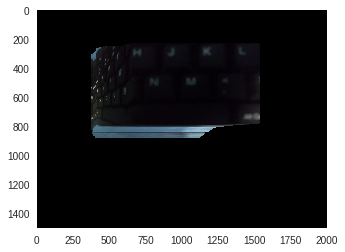

In [245]:
import cv2 as cv
cap = cv.VideoCapture('test8.mp4')
blank_image = np.zeros((1500,2000,3), np.uint8)
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_frame=cv.resize(old_frame,(720,480))
offsetx=400
offsety=400

old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
ho,wo= old_gray.shape[0],old_gray.shape[1]
blank_image[offsety:offsety+ho,offsetx:offsetx+wo,:]=old_frame
n=10
pl0 = Generate_points(wo/n,1,ho).reshape(-1,1,2).astype(np.float32)
pr0 = Generate_points(wo*(n-1)/n,1,ho).reshape(-1,1,2).astype(np.float32) 

# pl0 = np.asarray([[[wo/n,ho*(n/5)/n]],[[wo/n,ho*(n/4)/n]],[[wo/n,ho*(n/3)/n]],[[wo/n,ho*(n/2)/n]],[[wo/n,ho*(n/1.5)/n]]])
# pl0 = np.array(pl0).reshape(-1,1,2).astype(np.float32) 
# pr0 = np.asarray([[[wo*(n-1)/n,ho*(n/5)/n]],[[wo*(n-1)/n,ho*(n/4)/n]],[[wo*(n-1)/n,ho*(n/3)/n]],[[wo*(n-1)/n,ho*(n/2)/n]],[[wo*(n-1)/n,ho*(n/1.5)/n]]])
# pr0 = np.array(pr0).reshape(-1,1,2).astype(np.float32)

# Create a mask image for drawing purposes
# mask = np.zeros_like(old_frame)
counter=0

while(ret):
    counter+=1
    ret,frame = cap.read()
#     counter%3!=0 or 
    if(ret==False):
      continue
    
#     print(ret)
    frame= cv.resize(frame,(720,480))
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calculate optical flow
    pl1, stl, errl = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, pl0, None, **lk_params)
    pr1, str, errr = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, pr0, None, **lk_params)
#     print(pl1)
    good_newl = pl1[stl==1]
    good_oldl = pl0[stl==1]
    good_newr = pr1[str==1]
    good_oldr = pr0[str==1]
#     print(pr1.size,pr0.size)
#     good_newl = pl1[errl<np.mean(errl)]
#     good_oldl = pl0[errl<np.mean(errl)]
#     good_newr = pr1[errr<np.mean(errr)]
#     good_oldr = pr0[errr<np.mean(errr)] 
#     print(pr1.size,pr0.size,good_newr.size,good_oldr.size)
    
    try:
      try:  
        x_deflection_l=int(np.mean(good_newl[:,0]))-int(np.mean(good_oldl[:,0]))
        y_deflection_l=int(np.mean(good_newl[:,1]))-int(np.mean(good_oldl[:,1]))
        x_deflection_r=int(np.mean(good_newr[:,0]))-int(np.mean(good_oldr[:,0]))
        y_deflection_r=int(np.mean(good_newr[:,1]))-int(np.mean(good_oldr[:,1]))
      except:
        pass
  #     print(x_deflection_l, x_deflection_r, y_deflection_l, y_deflection_r)

  #     if abs(x_deflection_l)==abs(x_deflection_r) and x_deflection_l!=x_deflection_r:
      if x_deflection_l*x_deflection_r<0:  #handling z axis
        change=(x_deflection_l-x_deflection_r)
        ho= ho+int(change*ho/wo)
        wo= wo+change
        offsety-=int(change//2)
        offsetx-=int(change//2)
  #       print("resizing", ho, wo,change)
  #     if(y_deflection_l*y_deflection_r<0):
  #       print("rotating", y_deflection_l-y_deflection_r)
      frame= cv.resize(frame,(wo,ho))



      offsety=offsety- (y_deflection_l+y_deflection_r)//2
      offsetx=offsetx- (x_deflection_l+x_deflection_r)//2
  #     print(offsety, offsety+ho, offsetx, offsetx+wo, ho, wo,frame.shape )
      blank_image[offsety:offsety+ho,offsetx:offsetx+wo,:]=frame
    except:
      print("1")
      pass
    old_gray = frame_gray.copy()

#     frame = imutils.rotate(frame, angle)
    pl0 = Generate_points(wo/n,1,ho).reshape(-1,1,2).astype(np.float32)
    pr0 = Generate_points(wo*(n-1)/n,1,ho).reshape(-1,1,2).astype(np.float32) 
    
    
cv.destroyAllWindows()
cap.release()


plt.imshow(blank_image)
plt.grid(False)

In [0]:
    x_diflection=int(np.sum(good_newl[:,0]*-1*good_new_errl/np.sum(-1*good_new_errl)))-int(np.sum(good_oldl[:,0]*-1*good_new_errl/np.sum(-1*good_new_errl)))
    y_diflection=int(np.sum(good_newl[:,0]*-1*good_new_errl/np.sum(-1*good_new_errl)))-int(np.sum(good_oldl[:,0]*-1*good_new_errl/np.sum(-1*good_new_errl)))

In [0]:
    # draw the tracks
#     for i,(new,old) in enumerate(zip(good_new,good_old)):
#         a,b = new.ravel()
#         c,d = old.ravel()
#         mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 2)
#         frame = cv.circle(frame,(a,b),5,color[i].tolist(),-1)
#     img = cv.add(frame,mask)
#     plt.imshow(img)
#     k = cv.waitKey(30) & 0xff
#     if k == 27:
#         break
    # Now update the previous frame and previous points